(final_template)=

# Final Project: Functions

:::{epigraph}

-- Student name: Ngoc Linh Le
:::

This file contains the functions used in the Final project analysis, which serve:
- Generating the point estimates
- Generating confidence interval
- Computing the difference in means between control and treatment groups
- Propensity Score Matching: fitting propensity score, pair matching without replacement
- Drawing love plots

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import ipywidgets as widgets
from ipywidgets import interact_manual
from IPython.display import Image

### Estimates and Confidence Interval

In [27]:
def bootstrap_ci(bootstrap_values, alpha=0.05):
    """
    Computes the confidence interval using the percentile method.

    Args:
        bootstrap_values (list[float]): the bootstrapped values
        alpha (float): the significance level, defaults to 0.05

    Returns:
        list[float]: the confidence interval [lower, upper]
    """
    lower = np.percentile(bootstrap_values, alpha * 100)
    upper = np.percentile(bootstrap_values, (1 - alpha) * 100)

    return [lower, upper]


In [28]:
if __name__ == '__main__':
    bootstrap_values = [1.0,2.0,3.0,4.0,2.0,1.0,1.0]
    print(bootstrap_ci(bootstrap_values))

[np.float64(1.0), np.float64(3.6999999999999993)]


In [29]:
def bootstrap_dfs(df, n_bootstraps=1000):
    """
    Bootstraps the dataframe `n_bootstraps` times.

    Args:
        df (pd.DataFrame): the dataframe to bootstrap
        n_bootstraps (int): the number of bootstraps to generate

    Returns:
        list[pd.DataFrame]: a list of bootstrapped dataframes
    """
    bootstrap_dfs = []

    for i in range(n_bootstraps):
        bootstrap_dfs.append(df.sample(frac=1, replace=True))
        
    return bootstrap_dfs


In [30]:
if __name__ == '__main__':
    df = pd.DataFrame({
        'T': [1,1,0],
        'Y': [2,3,4]
    })
    
    print(bootstrap_dfs(df,n_bootstraps=5))

[   T  Y
1  1  3
2  0  4
1  1  3,    T  Y
1  1  3
0  1  2
0  1  2,    T  Y
2  0  4
0  1  2
1  1  3,    T  Y
2  0  4
2  0  4
0  1  2,    T  Y
2  0  4
2  0  4
1  1  3]


In [31]:
# Difference in means
def reg_diff_in_means(data, treat_col, outcome_col):
    """
    Computes the difference in means between the treatment and control groups using a regression model.

    Args:
        data (pd.DataFrame): the dataframe containing the data
        outcome_col (str): the name of the outcome variable
        treat_col (str): the name of the treatment variable

    Returns:
        float: the difference in means between the treatment and control groups
    """
    formula = f'{outcome_col} ~ 1 + {treat_col}'
    reg_res = smf.ols(formula, data).fit()

    return reg_res.params[treat_col]

In [32]:
if __name__ == "__main__":
    df = pd.DataFrame({
        'T': [1,1,0],
        'Y': [2,3,4]
    })
    print(reg_diff_in_means(data=df, treat_col='T', outcome_col='Y'))
    

-1.4999999999999991


In [33]:
def generate_estimates(data, estimator_func, treat_col, outcome_col, n_bootstraps=1000):
    """
    Computes the point estimate the and bootstrapped 95% confidence interval for an estimator function.

    Args:
        data (pd.DataFrame): the dataframe containing the data
        estimator_func (function): the estimator function to use
        treat_col (str): the name of the treatment variable
        outcome_col (str): the name of the outcome variable
        n_bootstraps (int): the number of bootstraps to use

    Returns:
        dict: a dictionary containing the point estimate, bootstrapped confidence interval, and bootstrapped values
    """
    point_estimate = estimator_func(data, treat_col, outcome_col)

    bootstrap_values = []

    # generate bootstrap samples:
    bootstrap_samples = bootstrap_dfs(data, n_bootstraps)

    for df in bootstrap_samples:
        bootstrap_values.append(estimator_func(df, treat_col, outcome_col))

    ci = bootstrap_ci(bootstrap_values, alpha=0.05)

    return {
        'point_estimate': point_estimate,
        'ci': ci,
        'bootstrap_values': bootstrap_values
    }
    

In [34]:
if __name__ == '__main__':
    df = pd.DataFrame({
        'T': [1,1,0],
        'Y': [2,3,4]
    })

    print(generate_estimates(
        data=df, 
        estimator_func=reg_diff_in_means, 
        treat_col="T", 
        outcome_col="Y", 
        n_bootstraps=5)
    )

{'point_estimate': np.float64(-1.4999999999999991), 'ci': [np.float64(-1.9), np.float64(1.466666666666666)], 'bootstrap_values': [np.float64(-1.5), np.float64(1.4999999999999993), np.float64(-2.0), np.float64(1.3333333333333328), np.float64(-1.0000000000000002)]}


## Propensity Score Matching (PSM)

By PSM, we distill all the covariates into **propensity score $e(X)$**, which is the probability of receiving the treatment assignment $T$ given confounders $X$ (base line characteristics).

$$
e(X) = P(T=1 | X) \in [0,1]
$$
According to the **Propensity score theorem**, if we control for propensity score $e(X)$, we control for the effect of all the **observed** confouders.

$$
\text{If we have: } \quad Y(1), Y(0) \;\perp\; T \mid X,
$$
$$
\text{then: } \quad Y(1), Y(0) \;\perp\; T \mid e(X),
$$

- For every treated unit:
  - Find one control unit that has the closest propensity score
  - Then we match without replacement by removing that counted control unit from future consideration
- Compute the difference-in-means between the treated and control units

For PSM, we will conduct logistic regression with `smf.logit`, considering the current dataset and formula:

$$
\log\left(
\frac{e(X)}{1 - e(X)}
\right)
=
\beta_0 + \sum_{k=1}^{n} \beta_k X_k,
\quad
\text{where } e(X) = P(T = 1 \mid X).
$$

in which $T$ is treatment assignment, and $X$ include the covarates.

In [35]:
def fit_propensity_score(df, treatment, covariates):
    """
    Fits a propensity score model using the covariates and treatment assignment.

    Args:
        df (pd.DataFrame): The dataframe containing the covariates and treatment assignment.
        treatment (str): The name of the treatment variable.
        covariates (list[str]): The list of covariates to include in the propensity score model.

    Returns:
        pd.Series: A series of the fitted propensity scores.
    """
    # TODO your code here
    formula = f'{treatment} ~ 1 + ' + " + ".join(covariates)
    propensity_model = smf.logit(formula, data=df).fit()

    # predict the probability of a patient receiving a treatment based on a set of covariates (baseline characteristics)
    fitted_propensity_scores = propensity_model.predict(df)
    return fitted_propensity_scores

In [36]:
if __name__ == "__main__":
    df = pd.DataFrame({
        "T": [1,0,1,1,0],
        "age": [12,12,6,8,9],
        "gender": [1,1,0,0,1]
    })
    covariates = ["age", "gender"]
    
    print(fit_propensity_score(df, "T", covariates))

         Current function value: 0.277259
         Iterations: 35
0    5.000000e-01
1    5.000000e-01
2    1.000000e+00
3    1.000000e+00
4    5.452808e-11
dtype: float64


/opt/tljh/user/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next, we'll implement **pair matching without replacement** using a **greedy algorithm**.
This is broken into two functions:
- `select_closest_control_unit`: selects the closest control unit to the given treated propensity score/
- `greedy_pair_match`: builds a pair matched dataframe for the treated units.

In [37]:
def select_closest_control_unit(control_df, prop_score_treated, prop_score_col):
    """
    Selects the closest control unit to the given treated propensity score.

    Returns a tuple with two elements:
    - the first element is a pd.Series with a single row that corresponds to the control unit that is closest to the treated unit.
    - the second element is a pd.DataFrame with the remaining control units.

    Args:
        control_df (pd.DataFrame): The dataframe containing the control units.
        prop_score_treated (float): The propensity score of the treated unit.
        prop_score_col (str): The name of the propensity score column

    Returns:
        (pd.Series, pd.DataFrame): A tuple of the matched control unit row and the remaining control units
    """
    closest_control_row = None 
    control_df = control_df.copy()

    # Calculate the absolute difference in propensity scores, store in a new column called 'distance'
    control_df['distance'] = np.abs(control_df[prop_score_col] - prop_score_treated)

    # The closest control unit is the one with the minimum distance
    min_dist_idx = control_df['distance'].idxmin()
    closest_control_row = control_df.loc[min_dist_idx] # get rows with index
    
    # Drop the matched control unit from the pool
    control_df = control_df.drop(min_dist_idx)
    # Return the matched control unit row and the remaining control units
    return closest_control_row, control_df

In [38]:
if __name__ == "__main__":
    control_df = pd.DataFrame({
        "propensity_score": [0.10, 0.25, 0.40, 0.60, 0.85]
    })

    prop_score_treated = 0.50

    matched, remaining = select_closest_control_unit(
        control_df,
        prop_score_treated,
        "propensity_score"
    )

    print("Matched control unit:")
    print(matched)

    print("\nRemaining control units:")
    print(remaining)

Matched control unit:
propensity_score    0.4
distance            0.1
Name: 2, dtype: float64

Remaining control units:
   propensity_score  distance
0              0.10      0.40
1              0.25      0.25
3              0.60      0.10
4              0.85      0.35


In [46]:
def greedy_pair_match(df, treat_col, prop_score_col):
    """
    Implements a greedy pair matching estimator without replacement.

    Args:
        df (pd.DataFrame): The dataframe containing the covariates and treatment assignment.
        treat_col (str): The name of the treatment variable column, assumed to be binary
        prop_score_col (str): The name of the propensity score column

    Returns:
        pd.DataFrame: A new dataframe of the matched data, which should have the same columns as the input dataframe.
    """
    df = df.copy()
    # Sort the dataframe by the propensity score to make the matching faster
    df = df.sort_values(by=prop_score_col)

    # Separate out the treated and control units
    treated_units = df[df[treat_col] == 1]
    control_units = df[df[treat_col] == 0]
    
    # track the matched rows (treated and control) in a list
    matched_units_list = []
    # Iterate through the treated units and call the select_closest_control_unit 
    # to find the closest control unit
    for i, row in treated_units.iterrows():
        """
        Args:
        control_df (pd.DataFrame): The dataframe containing the control units.
        prop_score_treated (float): The propensity score of the treated unit.
        prop_score_col (str): The name of the propensity score column, default is 'propensity_score'
        """
        prop_score_treated = row[prop_score_col]
        closest_control_row, control_units = select_closest_control_unit(control_units, prop_score_treated, prop_score_col)
        
        # add both the matched treated and control units to the matched_units_list
        matched_units_list.append(row)
        matched_units_list.append(closest_control_row)
        
    # Create a dataframe from the matched_units_list
    matched_df = pd.DataFrame(matched_units_list)

    # Drop the distance column to clean up the dataframe
    matched_df = matched_df.drop(columns=['distance'])

    # Return the matched dataframe
    return matched_df

In [48]:
if __name__ == "__main__":
    df = pd.DataFrame({
        "id": [0, 1, 2, 3, 4, 5],
        "T":  [1, 0, 1, 0, 0, 0],
        "propensity_score": [0.20, 0.10, 0.80, 0.75, 0.85, 0.30],
        "age": [12, 13, 11, 14, 15, 12],
        "gender": [1, 0, 1, 0, 1, 0],
    }).set_index("id")

    print("Original data:")
    print(df)

    matched_df = greedy_pair_match(
        df=df,
        treat_col="T",
        prop_score_col="propensity_score"
    )

    print("\nMatched data (greedy PSM without replacement):")
    print(matched_df)

Original data:
    T  propensity_score  age  gender
id                                  
0   1              0.20   12       1
1   0              0.10   13       0
2   1              0.80   11       1
3   0              0.75   14       0
4   0              0.85   15       1
5   0              0.30   12       0

Matched data (greedy PSM without replacement):
     T  propensity_score   age  gender
0  1.0              0.20  12.0     1.0
5  0.0              0.30  12.0     0.0
2  1.0              0.80  11.0     1.0
4  0.0              0.85  15.0     1.0


## Love plots

For assessing the covariate balance before and after matching, we use love plots. The y-axis shows all the covariates that are included in the propensity score model, and the x-axis shows the standardized difference between the treated and control units for each covariate. It is noted that the **absolute value of the standardized differences should be less than 0.1 for all the covariates** in order to have good balance, which is indicated by the vertical line in their plot.

We'll implement a function for generating love plots for our subsequent analyses. The first step is to calculate the **standardized difference $d_X$ for a given covariate $X$**, which is defined as:

$$
d_X = \frac{\hat{E}[X \mid T=1] - \hat{E}[X \mid T=0]} { \large \sqrt{\frac{\hat{V}[X \mid T=1] + \hat{V}[X \mid T=0]} {2}}}
$$

Where $\hat{E}[X \mid T=1]$ is the estimated expectation (mean) of the covariate $X$ for the treated units and $\hat{V}[X \mid T=1]$ is the estimated variance of the covariate $X$ for the treated units.

In [52]:
def standardized_difference(df, covariate, treat_col):
    """
    Calculates the standardized difference for a given covariate between treated and control units.

    Args:
        df (pd.DataFrame): The dataframe containing the data to be analyzed
        covariate (str): The name of the covariate to analyze
        treat_col (str): The name of the treatment variable column

    Returns:
        float: The standardized difference for the given covariate
    """
    # Calculate the mean and variance of the covariate for the treated and control units
    treated_units = df.loc[df[treat_col] == 1, covariate]
    control_units = df.loc[df[treat_col] == 0, covariate]
    mean_treated_units = treated_units.mean()
    mean_control_units = control_units.mean()
    variance_treated_units = treated_units.var()
    variance_control_units = control_units.var()

    # Calculate the standardized difference
    std_diff = (mean_treated_units - mean_control_units) / np.sqrt((variance_treated_units + variance_control_units)/2)
     
    return std_diff

In [53]:
if __name__ == "__main__":
    df = pd.DataFrame({
        "id": [0, 1, 2, 3, 4, 5],
        "T":  [1, 0, 1, 0, 0, 0],
        "propensity_score": [0.20, 0.10, 0.80, 0.75, 0.85, 0.30],
        "age": [12, 13, 11, 14, 15, 12],
        "gender": [1, 0, 1, 0, 1, 0],
    }).set_index("id")

    print("Original data:")
    print(df)

    std_diff = greedy_pair_match(
        df=df,
        treat_col="T",
        prop_score_col="propensity_score"
    ) 
    
    print("Standardized Difference")
    print(matched_df)

Original data:
    T  propensity_score  age  gender
id                                  
0   1              0.20   12       1
1   0              0.10   13       0
2   1              0.80   11       1
3   0              0.75   14       0
4   0              0.85   15       1
5   0              0.30   12       0
Standardized Difference
     T  propensity_score   age  gender
0  1.0              0.20  12.0     1.0
5  0.0              0.30  12.0     0.0
2  1.0              0.80  11.0     1.0
4  0.0              0.85  15.0     1.0


In [54]:
def std_diff_dataframe(matched_df, unmatched_df, treat_col, covariates, threshold = 0.1):
    """
    Builds a dataframe of standardized differences for plotting.

    Args:
        matched_df (pd.DataFrame): The dataframe containing the matched data
        unmatched_df (pd.DataFrame): The dataframe containing the unmatched data
        treat_col (str): The name of the treatment variable column
        covariates (list): A list of the covariates to calculate the standardized differences for

    Returns:
        pd.DataFrame: A dataframe of standardized differences in the long format described above with columns:
        - covariate: the covariate name
        - std_diff: the standardized difference
        - data_source: the source of the data (matched or unmatched)
    """
    # create a dataframe with the covariate, the standardized difference for the matched data
    matched_dict = {
        'covariate': [],
        'std_diff': [],
        'data_source': []
    }

    unmatched_dict = {
        'covariate': [],
        'std_diff': [],
        'data_source': []
    }

    # populate the dictionary with the standardized differences for each covariate
    for covariate in covariates:
        std_diff = standardized_difference(matched_df, covariate, treat_col)
        matched_dict["covariate"].append(covariate)
        matched_dict["std_diff"].append(std_diff)
        if std_diff < threshold:
            matched_dict["data_source"].append("matched")
        else:
            matched_dict["data_source"].append("unmatched")

    for covariate in covariates:
        std_diff = standardized_difference(unmatched_df, covariate, treat_col)
        unmatched_dict["covariate"].append(covariate)
        unmatched_dict["std_diff"].append(std_diff)
        if std_diff < threshold:
            unmatched_dict["data_source"].append("matched")
        else:
            unmatched_dict["data_source"].append("unmatched")
        
    # create a dataframe from the dictionary for the matched data
    matched_std_diffs = pd.DataFrame(matched_dict)

    # repeat the process for the unmatched data
    unmatched_std_diffs = pd.DataFrame(unmatched_dict)

    # concatenate the two dataframes
    std_diff_df = pd.concat([matched_std_diffs, unmatched_std_diffs], ignore_index=True)
    # std_diff_df.reset_index(drop=True) # drop/ignore index to prevent ValueError: cannot reindex on an axis with duplicate labels

    return std_diff_df

In [55]:
if __name__ == "__main__":
    df = pd.DataFrame({
        "id": [0, 1, 2, 3, 4, 5],
        "T":  [1, 0, 1, 0, 0, 0],
        "propensity_score": [0.20, 0.10, 0.80, 0.75, 0.85, 0.30],
        "age": [12, 13, 11, 14, 15, 12],
        "gender": [1, 0, 1, 0, 1, 0],
    }).set_index("id")
    covariates = ["age", "gender"]

    print("Original data:")
    print(df)

    matched_df = greedy_pair_match(
        df=df,
        treat_col="T",
        prop_score_col="propensity_score"
    )

    print("\nMatched data (greedy PSM without replacement):")
    print(matched_df)

    print("\n Standardized difference dataframe")
    print(std_diff_dataframe(matched_df, df, "T", covariates, threshold = 0.1))

Original data:
    T  propensity_score  age  gender
id                                  
0   1              0.20   12       1
1   0              0.10   13       0
2   1              0.80   11       1
3   0              0.75   14       0
4   0              0.85   15       1
5   0              0.30   12       0

Matched data (greedy PSM without replacement):
     T  propensity_score   age  gender
0  1.0              0.20  12.0     1.0
5  0.0              0.30  12.0     0.0
2  1.0              0.80  11.0     1.0
4  0.0              0.85  15.0     1.0

 Standardized difference dataframe
  covariate  std_diff data_source
0       age -1.264911     matched
1    gender  1.000000   unmatched
2       age -1.921538     matched
3    gender  2.121320   unmatched


In [57]:
def build_love_plot(std_diff_df):
    """
    Builds a love plot from a dataframe of standardized differences.

    Args:
        std_diff_df (pd.DataFrame): The dataframe of standardized differences
        ax (matplotlib.axes.Axes): The axis to plot the love plot on

    Returns:
        matplotlib.axes.Axes: The axis with the love plot plotted
    """
    # generate a list of the covariates sorted by the unmatched data's standardized difference to pass into the `order` parameter
    order = std_diff_df.sort_values("std_diff")["covariate"] # sort by std_diff and get the covariate

    # plot the stripplot with the given parameters
    ax = sns.stripplot(
        data=std_diff_df,
        x="std_diff",
        y="covariate",
        hue="data_source",
        jitter=False,
        size=8,
        order=order
    )

    # draw the vertical lines at 0.1 and -0.1
    ax.axvline(x=-0.1, color="black", linestyle="--")
    ax.axvline(x=0.1, color="black", linestyle="--")
    ax.set_title("Love Plot")
    ax.set_xlabel("Standardized Difference")
    ax.set_ylabel("Covariate")
    ax.legend(title="Data Source")

    plt.show()

    return ax


 Standardized difference dataframe


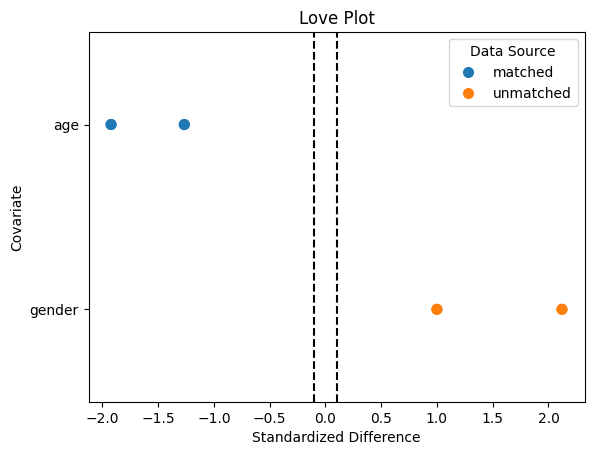

In [58]:
if __name__ == "__main__":
    df = pd.DataFrame({
        "id": [0, 1, 2, 3, 4, 5],
        "T":  [1, 0, 1, 0, 0, 0],
        "propensity_score": [0.20, 0.10, 0.80, 0.75, 0.85, 0.30],
        "age": [12, 13, 11, 14, 15, 12],
        "gender": [1, 0, 1, 0, 1, 0],
    }).set_index("id")
    covariates = ["age", "gender"]
    matched_df = greedy_pair_match(
        df=df,
        treat_col="T",
        prop_score_col="propensity_score"
    )
    
    print("\n Standardized difference dataframe")
    std_diff_df = std_diff_dataframe(matched_df, df, "T", covariates, threshold = 0.1)
    build_love_plot(std_diff_df)

## Estimator error bar

In [61]:
def build_estimator_error_bars(matched_estimates, ax):
    """
    Generates the error bar plots for the estimators, 
    where the x-axis is the estimator name, the y-axis is the point estimate, and the error bars are the 95% confidence interval.

    Args:
        estimator (dict): Estimator results
        ax (plt.Axes): The axis to plot the error bars on

    Returns:
        ax (plt.Axes): The axis with the error bars plotted
    """
    pe = matched_estimates["point_estimate"]
    lower, upper = matched_estimates["ci"]

    # distances from point estimate
    yerr = [[pe - lower], [upper - pe]]

    ax.errorbar(
        x=[0],
        y=[pe],
        yerr=yerr,
        fmt="o",
        capsize=6,
        color=sns.color_palette()[0]
    )
    
    ax.set_ylabel("Estimated treatment effect")
    ax.set_title("Matched Treatment Effect (95% CI)")

    return ax

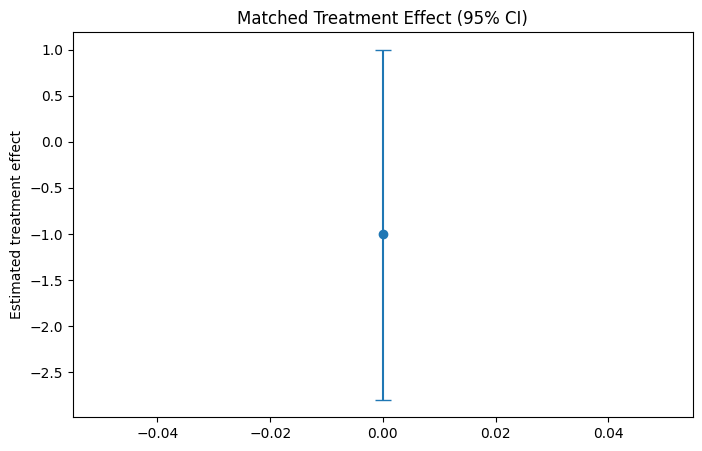

In [65]:
if __name__ == "__main__":
    df = pd.DataFrame({
        'T': [1,0,1,0],
        'Y': [2,3,4,5]
    })

    matched_estimates = generate_estimates(
        data=df, 
        estimator_func=reg_diff_in_means, 
        treat_col="T", 
        outcome_col="Y", 
        n_bootstraps=5
    )
    
    fig, ax = plt.subplots(figsize=(8,5))
    build_estimator_error_bars(matched_estimates, ax)

    plt.show()